# Movie Rating Prediction Using Naive Bayes


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Introduction

In this project, we will analyze movie reviews and determine whether a movie is good or bad.  The movie reviews data has been downloaded from the [Rotten Tomatoes](http://www.rottentomatoes.com) website. It contains metadata for ~65,000 different movies

Our aim here is to develop a Naive Bayes classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [5]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.csv")
reviews = reviews[~reviews.review_content.isnull()]
reviews = reviews[reviews.review_type != 'none']
reviews = reviews[reviews.review_content.str.len() > 0]
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [7]:
# enter your code below

print("Number of unique reviews: {}".format(len(reviews.review_content.unique())))
print("Number of unique reviewers: {}".format(len(reviews.critic_name.unique())))
print("Number of unique movies in 'reviews' dataset: {}".format(len(reviews.rotten_tomatoes_link.unique())))
print("Number of unqiue movies in 'movies' dataset: {}".format(len(movies.movie_title.unique())))
print("Number of unique publications: {}".format(len(reviews.rotten_tomatoes_link.unique())))

Number of unique reviews: 949181
Number of unique reviewers: 11074
Number of unique movies in 'reviews' dataset: 17697
Number of unqiue movies in 'movies' dataset: 17106
Number of unique publications: 17697


**Section 1.1**

It is worth noting that the number of _unique_ quotes are different from the _total_ number of quotes, which means that there are some quotes which are _exactly the same_. For instance, the quote _'A masterpiece.'_ was used by both Ben Walters and Geoff Andrew. However, there are other quotes, such as _'It's sick, slick and sensational.'_, which are duplicates. 

### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviewers.  Label your axes and make your histogram look professional.

Text(0, 0.5, 'Number of Reviewers')

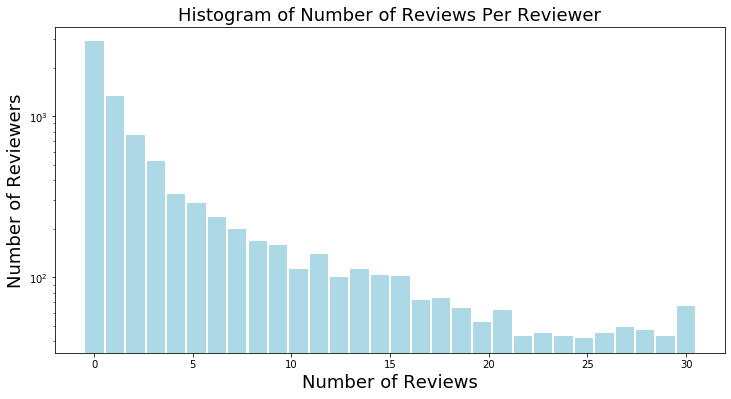

In [8]:
reviews['count'] = 1
reviewNum = reviews.groupby('critic_name').sum()['count']

plt.figure(figsize = (12,6))
plt.hist(reviewNum, Color = 'lightblue', bins = 30, range = (0,30+1), align = 'left', rwidth = 0.85)
plt.yscale('log', nonposy = 'clip')
plt.title('Histogram of Number of Reviews Per Reviewer', fontsize = 18)
plt.xlabel('Number of Reviews', fontsize = 18)
plt.ylabel('Number of Reviewers', fontsize = 18)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [9]:
mostReviews = reviewNum.sort_values(ascending = False)[0:30].index #extract top 30 critics with most reviews 
publication = pd.DataFrame(reviews.groupby('critic_name').publisher_name.unique()[mostReviews])
lastReview = pd.DataFrame(reviews.groupby('critic_name').review_date.max()[mostReviews])
firstReview = pd.DataFrame(reviews.groupby('critic_name').review_date.min()[mostReviews])
df = pd.concat([publication, firstReview, lastReview], axis = 1)
df.columns = ['Publication','Date of First Review','Date of Last Review']
df

,Publication,Date of First Review,Date of Last Review
critic_name,,,
Dennis Schwartz,[Dennis Schwartz Movie Reviews],2000-01-01,2020-09-29
Roger Ebert,"[Chicago Sun-Times, RogerEbert.com, Ebert & Ro...",1982-10-08,2020-07-18
Jeffrey M. Anderson,"[Combustible Celluloid, San Francisco Examiner...",2000-01-01,2020-10-10
Brian Orndorf,"[BrianOrndorf.com, FilmJerk.com, OhmyNews.com,...",2000-01-01,2020-09-21
Roger Moore,"[Orlando Sentinel, Movie Nation, Tribune News ...",1995-11-22,2020-10-14
Frank Swietek,[One Guy's Opinion],1995-06-30,2020-09-24
David Nusair,"[Reel Film Reviews, AskMen.com, About.com, rec...",2000-01-01,2020-10-21
Frederic and Mary Ann Brussat,[Spirituality & Practice],2000-01-01,2020-10-26
Rich Cline,"[Shadows on the Wall, Film Threat, Contactmusi...",2001-12-10,2020-10-09


**Section 1.3**

It should be noted that some of the review dates are erroneous. For example, the date of James Berardinelli's first review is 1800-01-01 00:00:00, which is likely a case of missing data. 

### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [10]:
movies.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [12]:
pd.options.mode.chained_assignment = None
cleanMovies = movies[~((movies.tomatometer_rating == '0') | (movies.tomatometer_rating == '\\N'))]
cleanMovies.loc[:,"tomatometer_rating"] = pd.to_numeric(cleanMovies['tomatometer_rating'])
avgAllMovies = cleanMovies.groupby('original_release_date').mean().tomatometer_rating

TypeError: nan is not a string

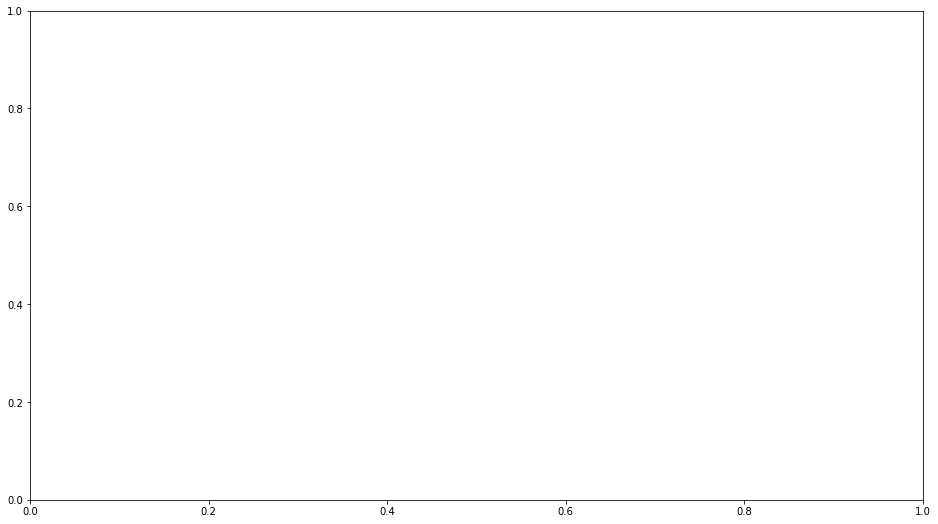

In [14]:
fig, ax = plt.subplots(figsize = (16,9))
plt.scatter(cleanMovies['original_release_date'],cleanMovies['tomatometer_rating'], marker = 'x', c = 'lightgreen')
plt.scatter(avgAllMovies.index, avgAllMovies, marker = 'x', c = 'orange')
ax.set_xlabel('Movie Release Year', fontsize = 18)
ax.set_ylabel('Average Rating Per Movie', fontsize = 18)
ax.set_title('Average Rating Per Movie Over Time', fontsize = 18)
ax.legend(['Average Rating For Each Movie','Average Rating For Each Year'], fontsize = 12)

**Section 1.4**

There is a general downward trend in the average movie rating given over time. It is difficult to attribute this decrease to any particular factor given the limited amount of information we have, but there might be two explanations for this trend: 

1. The expectations of the global audience and critics have been steadily increasing over time, leading to a decrease in average ratings. 

2. The quality of movies produced has indeed decline over time, leading to poorer average ratings. 

I would also argue that the average movie ratings obtained in the years _before_ 1980 may not be representative due to the small sample size available. As such, all inferences made from this general downward trend should only be taken with a pinch of salt or be further justified by other relevant data. 

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [11]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    if vectorizer == None: 
        vectorizer = CountVectorizer(min_df=0)
    text = list(reviews.quote)
    vectorizer.fit(text)
    X = vectorizer.transform(text)
    X = X.toarray()
    
    Y = np.asarray(reviews.fresh.map({'rotten': 0, 'fresh':1}))
    return X, Y

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
X, Y = make_xy(reviews)
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (13419, 20875)
Shape of Y: (13419,)


### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 50)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (10735, 20875)
Shape of X_test: (2684, 20875)
Shape of Y_train: (10735,)
Shape of Y_test: (2684,)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [13]:
from sklearn.naive_bayes import MultinomialNB

fitted_model = MultinomialNB()
fitted_model.fit(X_train, Y_train)
train_acc = fitted_model.score(X_train, Y_train)
test_acc = fitted_model.score(X_test, Y_test)
print("Training Accuracy: {}".format(train_acc))
print("Test Accuracy: {}".format(test_acc))

Training Accuracy: 0.9226828132277597
Test Accuracy: 0.7790611028315947


**Section 2.3**

There's a significant difference between the training and test accuracies obtained from the multinomial Naive Bayes classifier, which are calculated as 92.3% and 77.9% respectively. This might indicate some level of overfitting. 

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [31]:
alpha = 1
X, Y = make_xy(reviews)
rotten = Y == 0
fresh = ~rotten
p_rotten = rotten.sum()/len(Y)
p_fresh = fresh.sum()/len(Y)
logp_given_rotten = np.log10((X[rotten].sum(axis = 0) + alpha)/len(X[rotten]))
logp_given_rotten = np.log10(p_rotten) + logp_given_rotten.sum()
logp_given_fresh = np.log10((X[fresh].sum(axis = 0) + alpha)/len(X[fresh]))
logp_given_fresh = np.log(p_fresh) + logp_given_fresh.sum()

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [14]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3

print('The log likelihood of the model is:', log_likelihood(fitted_model, X_test, Y_test))

The log likelihood of the model is: -1447.3249047146842


### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [149]:
from sklearn.model_selection import KFold

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
kf = KFold(n_splits = 5, random_state = 50, shuffle = True)

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        print('Calculating for alpha =', alpha, 'and min_df =', min_df,'...')
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        fitted_model = MultinomialNB(alpha = alpha)
        
        list_loglike = []
        for train_index, test_index in kf.split(X):
            fitted_model.fit(X[train_index], Y[train_index])
            list_loglike.append(log_likelihood(fitted_model, X[test_index], Y[test_index]))
            
        if  np.mean(list_loglike) > max_loglike:
            best_alpha = alpha
            best_min_df = min_df
            max_loglike = np.mean(list_loglike)

print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))
print("Max Log Likelihood: {}".format(max_loglike))

Calculating for alpha = 0 and min_df = 1e-05 ...
Calculating for alpha = 0 and min_df = 0.0001 ...
Calculating for alpha = 0 and min_df = 0.001 ...
Calculating for alpha = 0 and min_df = 0.01 ...
Calculating for alpha = 0 and min_df = 0.1 ...
Calculating for alpha = 0.1 and min_df = 1e-05 ...
Calculating for alpha = 0.1 and min_df = 0.0001 ...
Calculating for alpha = 0.1 and min_df = 0.001 ...
Calculating for alpha = 0.1 and min_df = 0.01 ...
Calculating for alpha = 0.1 and min_df = 0.1 ...
Calculating for alpha = 1 and min_df = 1e-05 ...
Calculating for alpha = 1 and min_df = 0.0001 ...
Calculating for alpha = 1 and min_df = 0.001 ...
Calculating for alpha = 1 and min_df = 0.01 ...
Calculating for alpha = 1 and min_df = 0.1 ...
Calculating for alpha = 5 and min_df = 1e-05 ...
Calculating for alpha = 5 and min_df = 0.0001 ...
Calculating for alpha = 5 and min_df = 0.001 ...
Calculating for alpha = 5 and min_df = 0.01 ...
Calculating for alpha = 5 and min_df = 0.1 ...
Calculating for al

### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [15]:
X, Y = make_xy(reviews, CountVectorizer(min_df = 0.001))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 50)
fitted_model = MultinomialNB(alpha = 5)
fitted_model.fit(X_train, Y_train)
train_acc = fitted_model.score(X_train, Y_train)
test_acc = fitted_model.score(X_test, Y_test)
print("Training Accuracy: {}".format(train_acc))
print("Test Accuracy: {}".format(test_acc))

Training Accuracy: 0.7903120633442012
Test Accuracy: 0.7380774962742176


**Section 3.3**

Using the values which maximizes log likelihood, where alpha = 5 and min_df = 0.001, gives us a cross-validation training accuracy of 79.0% and cross-validation test accuracy of 73.8%. 

While the model demonstrates less overfitting now (due to the smaller differences in accuracy between training and test sets), both training and test accuracies have decreased from previously. 

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [151]:
from sklearn.model_selection import cross_val_score

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]


#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_acc = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        print('Calculating for alpha =', alpha, 'and min_df =', min_df,'...')
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        fitted_model = MultinomialNB(alpha = alpha)
        acc = cross_val_score(fitted_model, X, Y, cv = 5)            
        if  np.mean(acc) > max_acc:
            best_alpha = alpha
            best_min_df = min_df
            max_acc = np.mean(acc)

print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))
print("Max Accuracy: {}".format(max_acc))

Calculating for alpha = 0 and min_df = 1e-05 ...
Calculating for alpha = 0 and min_df = 0.0001 ...
Calculating for alpha = 0 and min_df = 0.001 ...
Calculating for alpha = 0 and min_df = 0.01 ...
Calculating for alpha = 0 and min_df = 0.1 ...
Calculating for alpha = 0.1 and min_df = 1e-05 ...
Calculating for alpha = 0.1 and min_df = 0.0001 ...
Calculating for alpha = 0.1 and min_df = 0.001 ...
Calculating for alpha = 0.1 and min_df = 0.01 ...
Calculating for alpha = 0.1 and min_df = 0.1 ...
Calculating for alpha = 1 and min_df = 1e-05 ...
Calculating for alpha = 1 and min_df = 0.0001 ...
Calculating for alpha = 1 and min_df = 0.001 ...
Calculating for alpha = 1 and min_df = 0.01 ...
Calculating for alpha = 1 and min_df = 0.1 ...
Calculating for alpha = 5 and min_df = 1e-05 ...
Calculating for alpha = 5 and min_df = 0.0001 ...
Calculating for alpha = 5 and min_df = 0.001 ...
Calculating for alpha = 5 and min_df = 0.01 ...
Calculating for alpha = 5 and min_df = 0.1 ...
Calculating for al

**Section 3.4**

In this section, I repeated the simulation with classification accuracy as an evaluation method (instead of log likelihood). It appears that the best alpha and best min_df values are 1 and 1e-05 respectively, both of which are different from the optimal values obtained when the log likelihood was used as an evaluation measure. 

In this case, we achieved a cross-validation test accuracy of about 77.1%. 

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [16]:
#training the model on all data, and using optimal parameters for maximizing log likelihood
vectorizer = CountVectorizer(min_df = 0.001)
X, Y = make_xy(reviews, vectorizer)
fitted_model = MultinomialNB(alpha = 5)
fitted_model.fit(X,Y)
I = np.identity(X.shape[1])

#finding the classification probability for each word
prob = fitted_model.predict_log_proba(I)

#words with a large difference between these two columns mean they cnn predict "fresh" or "rotten" well. 
#A large negative difference means the word predicts "fresh" well. A large positive difference means the word predicts "rotten" well.

diff = list(prob[:,0] - prob[:,1])
combine = pd.concat([pd.DataFrame(vectorizer.get_feature_names()),pd.DataFrame(diff),pd.DataFrame(prob)], axis = 1)
combine.columns = ['word','difference','predict rotten','predict fresh']
combine = combine.sort_values(by = 'difference')
combine[0:10]

,word,difference,predict rotten,predict fresh
1157,masterpiece,-2.323942,-2.417329,-0.093387
460,delight,-2.274645,-2.372528,-0.097883
1952,touching,-2.039269,-2.161596,-0.122327
1833,superb,-1.955748,-2.088055,-0.132307
1538,remarkable,-1.955748,-2.088055,-0.132307
974,intelligent,-1.923333,-2.059715,-0.136382
2132,witty,-1.905737,-2.044380,-0.138642
1811,stunning,-1.894688,-2.034767,-0.140080
643,extraordinary,-1.894688,-2.034767,-0.140080
352,complex,-1.886319,-2.027497,-0.141177


In [17]:
combine[-10:]

,word,difference,predict rotten,predict fresh
1937,tiresome,1.401149,-0.220190,-1.621339
1590,sadly,1.401149,-0.220190,-1.621339
2010,unfunny,1.432402,-0.214091,-1.646492
531,dull,1.439371,-0.212751,-1.652122
501,disappointment,1.470142,-0.206927,-1.677069
198,bland,1.575503,-0.188058,-1.763561
2011,uninspired,1.614723,-0.181443,-1.796166
1423,pointless,1.757824,-0.159070,-1.916894
1047,lame,1.790614,-0.154314,-1.944928
2009,unfortunately,2.045506,-0.121611,-2.167117


**Section 3.5**

**(a)** In determining the 10 words which predict "fresh" best, and the 10 words which predict "rotten" best, we need to find words with the _largest difference_ between the classification probabilities for "rotten" and "fresh". In the method shown above, a _large negative number_ (more negative) means the word predicts "fresh" best, while a _large positive number_ (more positive) means the word predicts "rotten" best. 

Judging from the 20 words printed out, it does seem like the Naive Bayes classifier is learning fairly well. All words in the first table can have strong positive meanings, while all words in the second table are often associated with negativity. 

**(b)** The probability of the model predicting "fresh" is given by the "predict fresh" column (last column) in the tables. Evidently, this value is much higher for the first table (words which predict "fresh" best) when compared to the second table (words which predict "rotten" best). 


### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [18]:
pd.set_option('display.max_colwidth', -1)
X, Y = make_xy(reviews, CountVectorizer(min_df = 0.001))
fitted_model = MultinomialNB(alpha = 5)
fitted_model.fit(X, Y)
wrong_predictions = fitted_model.predict(X) != Y
poor_performance = reviews.loc[list(wrong_predictions),['quote','fresh']]
poor_performance[0:5]

,quote,fresh
11,"The script, by Lasseter, Pete Docter, Andrew Stanton and Joe Ranft, is filled with clever gags that keep the two heroes at each other's throats and the plot on fast- forward.",fresh
16,"A gloomy special-effects extravaganza filled with grotesque images, generating fear and despair.",rotten
17,Walter Matthau and Jack Lemmon are awfully good at this sort of thing.,fresh
19,"Just don't expect their bickering to be on the level of Neil Simon, and you won't be disappointed.",fresh
22,"If you poke through Grumpy's cheap sentimentality, you'll find a worthy picture somewhere.",fresh


**Section 3.6**

**(a)** A critical assumption of the Naive Bayes classifier is that each word affects the 'freshness' probability independent of other words. This is erroneous because in many cases, the meaning of a review is formed by a _group of words_, and not the meaning of any particular word alone. 

For example, the third row of the reviews above was falsely classified as "rotten" when it is actually "fresh". This is likely due to the presence of the word "awfully", which has a negative connotation when taken on its own.

Similarly, in the fourth row, the occurrence of the word "disappointed" might have led to model misclassification.

In [19]:
text2 = (list(reviews.quote) + ['This movie is not remarkable, touching, or superb in any way'])
vectorizer = CountVectorizer(min_df=0.001)
vectorizer.fit(text2)
m = vectorizer.transform(text2)
m = m.toarray()[-1,:] #extract the last line, which is a vectorized version of the desired quote

In [20]:
X, Y = make_xy(reviews, CountVectorizer(min_df = 0.001))
fitted_model = MultinomialNB(alpha = 5)
fitted_model.fit(X, Y)
predicted_freshness_m = fitted_model.predict(m.reshape(1,-1))
print('The predicted freshness for \'This movie is not remarkable, touching, or superb in any way\' is :', predicted_freshness_m)

The predicted freshness for 'This movie is not remarkable, touching, or superb in any way' is : [1]


**Section 3.6** 

**(b)** As expected, due to the high occurrence of positive words (when taken on its own) such as "remarkable", "touching" and "superb", the critic was predicted to give a "fresh" rating. The Naive Bayes classifier failed to account for the presence of "not", which essentially flips the meaning of the review completely. 